In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import numpy as np

/home/hj/anaconda3/envs/nextpoi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nyc_emb = pd.read_csv('../data/nyc/graph/nyc_basic_embedding.csv')
tky_emb = pd.read_csv('../data/tky/graph/tky_basic_embedding.csv')

nyc_main_cat = pd.read_csv('../data/nyc/graph/nyc_main_category.csv')
tky_main_cat = pd.read_csv('../data/tky/graph/tky_main_category.csv')

nyc_graph = pd.read_csv('../data/nyc/graph/nyc_edge_features.csv')
tky_graph = pd.read_csv('../data/tky/graph/tky_edge_features.csv')

In [3]:
nyc_emb.head()

,geohash,Commercial/Services_weekday,Culture & Leisure_weekday,Educational_weekday,Healthcare & Welfare_weekday,Residential_weekday,Transportation_weekday,count_weekday,Commercial/Services_holiday,Culture & Leisure_holiday,...,highway_trunk,highway_trunk_link,highway_unclassified,oneway_False,oneway_True,bridge_no,bridge_yes,tunnel_building_passage,tunnel_no,tunnel_yes
0,dr5nzz,0.0,0.0,1.0,0.0,0.0,0.0,20.0,0.0,0.0,...,0.0,0.0,0.0,14.0,6.0,18.0,2.0,0.0,20.0,0.0
1,dr5ppn,1.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0,0.0,...,0.0,0.0,0.0,12.0,4.0,14.0,2.0,0.0,14.0,2.0
2,dr5ppt,0.0,0.0,0.0,0.0,0.0,1.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dr5pqc,0.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,0.0,...,0.0,0.0,0.0,102.0,2.0,104.0,0.0,0.0,104.0,0.0
4,dr5pqe,0.0,0.0,0.0,0.0,1.0,0.0,15.0,0.0,0.0,...,0.0,0.0,0.0,94.0,13.0,107.0,0.0,0.0,107.0,0.0


In [4]:
nyc_emb.shape, tky_emb.shape

((1123, 64), (1100, 64))

In [5]:
nyc_graph.head()

,geohash_start,geohash_end,weight
0,dr5nzz,dr5r00,2
1,dr5pr6,dr5prd,8
2,dr5prg,dr5pru,9
3,dr5pvb,dr5py1,2
4,dr5pwr,dr5pwx,2


In [6]:
def make_bidirectional_graph(graph):
    """
    주어진 그래프를 양방향 그래프로 변환합니다.
    :param graph: DataFrame - 'geohash_start', 'geohash_end', 'weight' 컬럼을 포함한 그래프 데이터프레임
    :return: DataFrame - 양방향 그래프 데이터프레임
    """
    # edge 양방향 확장
    graph_bidirectional = pd.concat([
        graph,
        graph.rename(columns={'geohash_start': 'geohash_end', 'geohash_end': 'geohash_start'})
    ])
    
    return graph_bidirectional

nyc_bigraph = make_bidirectional_graph(nyc_graph)
tky_bigraph = make_bidirectional_graph(tky_graph)

nyc_graph.shape, tky_graph.shape, nyc_bigraph.shape, tky_bigraph.shape

((1625, 3), (1887, 3), (3250, 3), (3774, 3))

In [7]:
nyc_main_cat.head()

,geohash,major_category_weekday,major_category_holiday,major_category_morning,major_category_afternoon,major_category_evening,major_category_night
0,dr5nzz,Educational,Educational,Educational,Unknown,Unknown,Unknown
1,dr5ppn,Commercial/Services,Commercial/Services,Commercial/Services,Commercial/Services,Commercial/Services,Unknown
2,dr5ppt,Transportation,Transportation,Transportation,Transportation,Transportation,Transportation
3,dr5pqc,Transportation,Transportation,Unknown,Unknown,Transportation,Transportation
4,dr5pqe,Residential,Residential,Residential,Residential,Residential,Residential


In [8]:
# 연결성 없이 고립된 노드 찾기
def find_isolated_geohashes(graph, emd):
    # 연결된 모든 geohash 추출
    connected_geos = set(graph['geohash_start']).union(set(graph['geohash_end']))
    all_geos = set(emd['geohash'])
    isolated_geos = all_geos - connected_geos

    print(f"💡 연결되지 않은 geohash 수: {len(isolated_geos)}개")
    
    return isolated_geos

print("NYC에서 연결되지 않은 geohash 수")
nyc_isolated_geos = find_isolated_geohashes(nyc_bigraph, nyc_emb)

print("TKY에서 연결되지 않은 geohash 수")
tky_isolated_geos = find_isolated_geohashes(tky_bigraph, tky_emb)


NYC에서 연결되지 않은 geohash 수
💡 연결되지 않은 geohash 수: 90개
TKY에서 연결되지 않은 geohash 수
💡 연결되지 않은 geohash 수: 40개


(목표 임베딩 차원)
* GPT2 → 768 (256)
* LLaMA → 4096 (1365)

In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

# 멀티 헤드 GAT 모델 정의
class MultiHeadGAT(nn.Module):
    def __init__(self, in_channels=64, hidden_channels=64, out_channels=256, heads=4, dropout=0.2):
        super().__init__()
        # 첫 번째 GAT 레이어: 멀티 헤드
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        # 두 번째 GAT 레이어: 출력용 단일 헤드
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        
        self.act = nn.PReLU()
        self.norm = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.act(x)
        x = self.dropout(x)    # 비선형성
        x = self.gat2(x, edge_index)
        x = self.norm(x)
        return x
    

# 학습시 positive pair 추출 (가장 유사한 것과 더 가까워 지게 학습할 필요는 없나?)
def get_positive_pairs(graph, main_cat_df, weight_thresh=1, cat_cols=None):
    """
    그래프 상 연결되어 있고, 지정된 조건의 주요 카테고리가 같은 경우를 Positive Pair로 선택하고
    shared_cats와 weight를 함께 저장
    """
    if cat_cols is None:
        cat_cols = [
            'major_category_weekday', 'major_category_holiday',
            'major_category_morning', 'major_category_afternoon',
            'major_category_evening', 'major_category_night'
        ]
    
    # geohash to category dictionary
    cat_dict = main_cat_df.set_index('geohash')[cat_cols].to_dict(orient='index')
    
    pos_pairs = []

    for _, row in graph.iterrows():
        g1, g2 = row['geohash_start'], row['geohash_end']
        weight = row['weight']

        if g1 in cat_dict and g2 in cat_dict:
            shared_cats = sum(cat_dict[g1][col] == cat_dict[g2][col] for col in cat_cols)
            if weight >= weight_thresh:
                pos_pairs.append((g1, g2, weight, shared_cats))
    
    return pos_pairs

# 연결성이 없는 노드의 positive pair 생성
def get_isolated_positive_pairs(isolated_geos, main_cat_df, cat_cols):
    """
    isolated_geos: set or list of geohash 값들 (연결이 없는 노드)
    emb: DataFrame - geohash 및 category column을 포함한 데이터프레임
    cat_cols: list - major_category_* 컬럼들
    """
    cat_dict = main_cat_df.set_index('geohash')[cat_cols].to_dict(orient='index')
    pos_pairs = []

    for g1 in isolated_geos:
        if g1 not in cat_dict:
            continue

        best_match = None
        best_score = -1

        for g2 in cat_dict:
            if g1 == g2:
                continue

            shared_cats = sum(
                cat_dict[g1][col] == cat_dict[g2][col]
                for col in cat_cols
            )

            if shared_cats > best_score:
                best_score = shared_cats
                best_match = g2

        if best_match is not None and best_score > 0:
            pos_pairs.append((
                g1,
                best_match,
                0.1,               # soft weight
                best_score / 2     # soft shared_cats
            ))

    return pos_pairs

def get_negative_pairs(pos_pairs, main_cat_df, graph_df, seed=42):
    """
    각 geohash에 대해 positive 수만큼 negative pair를 생성
    """
    random.seed(seed)
    
    geos = main_cat_df['geohash'].tolist()
    cat_cols = ['major_category_weekday', 'major_category_holiday',
                'major_category_morning', 'major_category_afternoon',
                'major_category_evening', 'major_category_night']
    cat_dict = main_cat_df.set_index('geohash')[cat_cols].to_dict(orient='index')

    # 연결된 pair 집합
    connected = set(zip(graph_df['geohash_start'], graph_df['geohash_end']))

    # 각 anchor별 positive 개수 집계
    pos_count = defaultdict(int)
    for g1, g2, _, _ in pos_pairs:
        pos_count[g1] += 1
        pos_count[g2] += 1  # 양방향 학습 시에는 양쪽 다 처리

    # negative pair 생성
    neg_pairs = []
    for g1 in pos_count:
        count = 0
        attempts = 0
        while count < pos_count[g1] and attempts < 200:
            g2 = random.choice(geos)
            if g1 == g2 or (g1, g2) in connected or (g2, g1) in connected:
                attempts += 1
                continue

            shared_cats = sum(
                cat_dict[g1][col] == cat_dict[g2][col]
                for col in cat_cols
            )
            if shared_cats == 0:
                neg_pairs.append((g1, g2))
                count += 1

            attempts += 1

    return neg_pairs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def make_space_embedding(emb, graph, pos_pairs, neg_pairs, epochs=100, lr=0.001, llm_model='GPT2'):
    
    if llm_model == 'GPT2':
        hidden_dim = 64
        output_dim = 256
    else:
        hidden_dim = 128
        output_dim = 1365
    
    geo2idx = {geo: idx for idx, geo in enumerate(emb['geohash'])}
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # feature 행렬 (scaling 적용)
    scaler = StandardScaler().fit(emb.drop(columns=['geohash']).values)
    X_np = scaler.transform(emb.drop(columns=['geohash']).values)
    X = torch.from_numpy(X_np).float().to(device)
    
    # edge_index 생성
    edge_list = [(geo2idx[row['geohash_start']], geo2idx[row['geohash_end']]) for _, row in graph.iterrows()] 
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # 모델 정의
    model = MultiHeadGAT(in_channels=X.shape[1], hidden_channels=hidden_dim, out_channels=output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_list = []
    
    # 학습 루프
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        embeddings = F.normalize(model(X, edge_index), p=2, dim=1)

        loss_pos = 0
        loss_neg = 0

        # positive pair loss
        for g1, g2, weight, shared_cats in pos_pairs:
            i, j = geo2idx[g1], geo2idx[g2]
            sim = F.cosine_similarity(embeddings[i].unsqueeze(0), embeddings[j].unsqueeze(0))
            pos_weight = max((np.log1p(weight) + shared_cats) / 2, 0.1)
            loss_pos += (1 - sim) * pos_weight

        # negative pair loss
        for g1, g2 in neg_pairs:
            i, j = geo2idx[g1], geo2idx[g2]
            sim = F.cosine_similarity(embeddings[i].unsqueeze(0), embeddings[j].unsqueeze(0))
            margin = 0.1     # negative sample이 너무 잘 반대로 구성되어 큰 페널티를 줄 필요 없음
            loss_neg += F.relu(sim - margin)

        # 평균 loss 계산
        loss_pos = loss_pos / len(pos_pairs)
        loss_neg = loss_neg / len(neg_pairs)
        loss = loss_pos + loss_neg

        loss.backward()
        optimizer.step()

        # 로그 출력 및 저장
        if (epoch+1) % 10 == 0 or (epoch+1) == 1 or epoch == epochs:
            print(f"Epoch {epoch+1:3d}/{epochs} - Loss: {loss.item():.4f} (Pos: {loss_pos.item():.4f}, Neg: {loss_neg.item():.4f})")
        loss_list.append((loss.item(), loss_pos.item(), loss_neg.item()))

    # 5) 최종 임베딩은 eval 모드에서 뽑고 CPU로 반환
    model.eval()
    with torch.no_grad():
        embeddings = F.normalize(model(X, edge_index), p=2, dim=1).detach().cpu()
        
    # 시각화
    loss_array = np.array(loss_list)
    plt.plot(loss_array[:, 0], label='Total Loss')
    plt.plot(loss_array[:, 1], label='Positive Loss')
    plt.plot(loss_array[:, 2], label='Negative Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Contrastive Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return model, embeddings, geo2idx

def count_pair_frequency(pos_pairs, neg_pairs):
    """
    각 geohash별로 pos/neg pair 개수를 세고 비교 출력
    """
    pos_count = defaultdict(int)
    neg_count = defaultdict(int)

    # 각 geohash가 anchor로 등장한 횟수 세기 (양방향 처리)
    for g1, g2, _, _ in pos_pairs:
        pos_count[g1] += 1
        pos_count[g2] += 1

    for g1, g2 in neg_pairs:
        neg_count[g1] += 1

    # 모든 geohash 집합 생성
    all_geos = set(pos_count.keys()).union(set(neg_count.keys()))

    mismatch = []
    for geo in sorted(all_geos):
        pos = pos_count.get(geo, 0)
        neg = neg_count.get(geo, 0)
        if pos != neg:
            mismatch.append((geo, pos, neg))

    if mismatch:
        print(f"⚠️ 총 {len(mismatch)}개의 geohash에서 pos/neg 개수가 불일치합니다.")
        for geo, pos, neg in mismatch[:10]:  # 상위 10개만 출력
            print(f"  - {geo}: pos={pos}, neg={neg}")
    else:
        print("✅ 모든 geohash에서 positive와 negative pair 개수가 정확히 일치합니다.")

    return mismatch

In [11]:
def get_space_embedding(emb, main_cat, isolated_geos, bigraph, epochs=100, lr=0.001, llm_model='GPT2'):
    """ 데이터 별로 최종 space embedding을 생성하는 함수

    1. 양방향 그래프에서 positive pair 추출
    2. isolated geohash에서 positive pair 추출
    3. negative pair 추출
    4. GAT 모델 학습 및 임베딩 생성

    Args:
        emb (_type_): _description_
        main_cat (_type_): _description_
        isolated_geos (bool): _description_
        bigraph (_type_): _description_
        epochs (int, optional): _description_. Defaults to 100.
        lr (float, optional): _description_. Defaults to 0.001.
        llm_model (str, optional): _description_. Defaults to 'GPT2'.

    Returns:
        _type_: _description_
    """
    cat_cols = ['major_category_weekday', 'major_category_holiday', 'major_category_morning', 'major_category_afternoon', 'major_category_evening', 'major_category_night']
    
    # pos pair 추출
    pos_pairs = get_positive_pairs(bigraph, main_cat, weight_thresh=1, cat_cols=cat_cols)
    isolated_pos_pairs = get_isolated_positive_pairs(isolated_geos=isolated_geos, main_cat_df=main_cat, cat_cols=cat_cols)
    all_pos_pairs = pos_pairs + isolated_pos_pairs
    
    # pos pair 통계량 확인
    # weight와 shared_cats 추출
    weights = [w for (_, _, w, _) in all_pos_pairs]
    shareds = [s for (_, _, _, s) in all_pos_pairs]

    # numpy array로 변환
    weights = np.array(weights)
    log_weights = np.log1p(weights)  # 로그 변환 (0으로 나누는 오류 방지)
    shareds = np.array(shareds)

    print("📊 [Weight]")
    print(f"Mean     : {weights.mean():.4f}")
    print(f"Min      : {weights.min():.4f}")
    print(f"Max      : {weights.max():.4f}")
    print(f"Std      : {weights.std():.4f}")

    print("📊 [Log Weight]")
    print(f"Mean     : {log_weights.mean():.4f}")
    print(f"Min      : {log_weights.min():.4f}")
    print(f"Max      : {log_weights.max():.4f}")
    print(f"Std      : {log_weights.std():.4f}")

    print("📊 [Shared Categories]")
    print(f"Mean     : {shareds.mean():.4f}")
    print(f"Min      : {shareds.min():.4f}")
    print(f"Max      : {shareds.max():.4f}")
    print(f"Std      : {shareds.std():.4f}")
    
    # neg pair 추출
    neg_pairs = get_negative_pairs(all_pos_pairs, main_cat, bigraph)
    
    # 개수 확인
    count_pair_frequency(all_pos_pairs, neg_pairs)
    
    # 임베딩 추출 
    model, embeddings, geo2idx = make_space_embedding(emb, bigraph, all_pos_pairs, neg_pairs, epochs=epochs, lr=lr, llm_model=llm_model)

    return model, embeddings, geo2idx, all_pos_pairs, neg_pairs

📊 [Weight]
Mean     : 7.2466
Min      : 0.1000
Max      : 26.0000
Std      : 5.3498
📊 [Log Weight]
Mean     : 1.8512
Min      : 0.0953
Max      : 3.2958
Std      : 0.7744
📊 [Shared Categories]
Mean     : 1.5775
Min      : 0.0000
Max      : 6.0000
Std      : 1.9306
✅ 모든 geohash에서 positive와 negative pair 개수가 정확히 일치합니다.
Epoch   1/100 - Loss: 0.2511 (Pos: 0.1972, Neg: 0.0539)
Epoch  10/100 - Loss: 0.1939 (Pos: 0.1432, Neg: 0.0507)
Epoch  20/100 - Loss: 0.1704 (Pos: 0.1238, Neg: 0.0466)
Epoch  30/100 - Loss: 0.1550 (Pos: 0.1120, Neg: 0.0430)
Epoch  40/100 - Loss: 0.1430 (Pos: 0.1031, Neg: 0.0399)
Epoch  50/100 - Loss: 0.1331 (Pos: 0.0957, Neg: 0.0374)
Epoch  60/100 - Loss: 0.1245 (Pos: 0.0891, Neg: 0.0355)
Epoch  70/100 - Loss: 0.1170 (Pos: 0.0837, Neg: 0.0333)
Epoch  80/100 - Loss: 0.1104 (Pos: 0.0789, Neg: 0.0316)
Epoch  90/100 - Loss: 0.1047 (Pos: 0.0745, Neg: 0.0302)
Epoch 100/100 - Loss: 0.0997 (Pos: 0.0707, Neg: 0.0290)


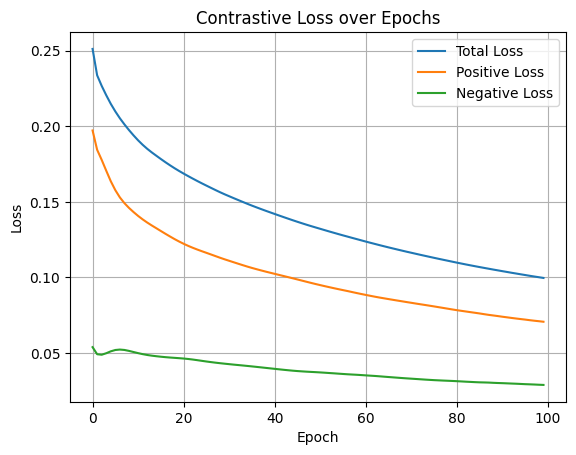

In [12]:
nyc_model, nyc_embeddings, nyc_geo2idx, nyc_pos_pairs, nyc_neg_pairs = get_space_embedding(
    emb=nyc_emb, 
    main_cat=nyc_main_cat,
    isolated_geos=nyc_isolated_geos, 
    bigraph=nyc_bigraph,
    epochs=100, 
    lr=0.001, 
    llm_model='GPT2'
) 

📊 [Weight]
Mean     : 12.6789
Min      : 0.1000
Max      : 43.0000
Std      : 9.1483
📊 [Log Weight]
Mean     : 2.3004
Min      : 0.0953
Max      : 3.7842
Std      : 0.8875
📊 [Shared Categories]
Mean     : 2.1981
Min      : 0.0000
Max      : 6.0000
Std      : 2.2440
✅ 모든 geohash에서 positive와 negative pair 개수가 정확히 일치합니다.
Epoch   1/100 - Loss: 0.4435 (Pos: 0.3812, Neg: 0.0623)
Epoch  10/100 - Loss: 0.3119 (Pos: 0.2181, Neg: 0.0939)
Epoch  20/100 - Loss: 0.2800 (Pos: 0.1887, Neg: 0.0913)
Epoch  30/100 - Loss: 0.2613 (Pos: 0.1740, Neg: 0.0873)
Epoch  40/100 - Loss: 0.2475 (Pos: 0.1640, Neg: 0.0836)
Epoch  50/100 - Loss: 0.2363 (Pos: 0.1565, Neg: 0.0798)
Epoch  60/100 - Loss: 0.2262 (Pos: 0.1484, Neg: 0.0778)
Epoch  70/100 - Loss: 0.2169 (Pos: 0.1418, Neg: 0.0752)
Epoch  80/100 - Loss: 0.2086 (Pos: 0.1344, Neg: 0.0742)
Epoch  90/100 - Loss: 0.2007 (Pos: 0.1282, Neg: 0.0726)
Epoch 100/100 - Loss: 0.1934 (Pos: 0.1222, Neg: 0.0712)


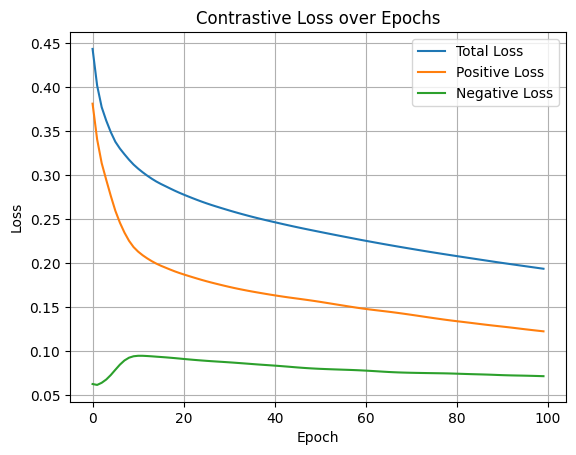

In [13]:
tky_model, tky_embeddings, tky_geo2idx, tky_pos_pairs, tky_neg_pairs = get_space_embedding(
    emb=tky_emb, 
    main_cat=tky_main_cat,
    isolated_geos=tky_isolated_geos, 
    bigraph=tky_bigraph,
    epochs=100, 
    lr=0.001, 
    llm_model='GPT2'
) 

In [14]:
# 결과 임베딩 저장
nyc_embedding_np = nyc_embeddings.cpu().numpy()
tky_embedding_np = tky_embeddings.cpu().numpy()

nyc_idx2geo = {idx: geo for geo, idx in nyc_geo2idx.items()}
tky_idx2geo = {idx: geo for geo, idx in tky_geo2idx.items()}

nyc_geo_list = [nyc_idx2geo[idx] for idx in range(len(nyc_idx2geo))]
tky_geo_list = [tky_idx2geo[idx] for idx in range(len(tky_idx2geo))]

nyc_final_space_embedding = pd.DataFrame(
    data=nyc_embedding_np, 
    index=nyc_geo_list, 
    columns=[f'feature_{i}' for i in range(nyc_embedding_np.shape[1])]
)

tky_final_space_embedding = pd.DataFrame(
    data=tky_embedding_np, 
    index=tky_geo_list, 
    columns=[f'feature_{i}' for i in range(tky_embedding_np.shape[1])]
)

In [15]:
# 최종 임베딩 저장
nyc_final_space_embedding.to_csv('../data/nyc/graph/nyc_gat_space_embedding.csv')
tky_final_space_embedding.to_csv('../data/tky/graph/tky_gat_space_embedding.csv')